In [178]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer,KNNImputer,IterativeImputer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC
import auxMethods as auxMethods
from statsmodels.multivariate.pca import PCA
from sklearn.metrics import mean_squared_error, r2_score


import seaborn as sns
import matplotlib.pyplot as plt

# Import the training file.



In [179]:
train_file = "train_data.csv"
df = pd.read_csv(train_file)
df

,Unnamed: 0,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0,76.0,1,4,NaN,0,1.0,0.0,2.9,0
1,1,63.0,1,3,0.0,0,1.0,0.0,4.7,0
2,2,64.0,0,2,0.0,0,0.0,0.0,NaN,0
3,3,56.0,0,3,1.0,0,1.0,0.0,2.9,0
4,4,67.0,1,3,1.0,0,3.0,1.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...
395,395,50.0,1,2,0.0,0,NaN,0.0,NaN,0
396,396,62.0,1,1,0.0,0,0.0,1.0,NaN,0
397,397,59.0,0,2,1.0,0,NaN,1.0,4.3,0
398,398,65.0,1,3,0.0,0,1.0,1.0,2.5,0


# Check column correlation

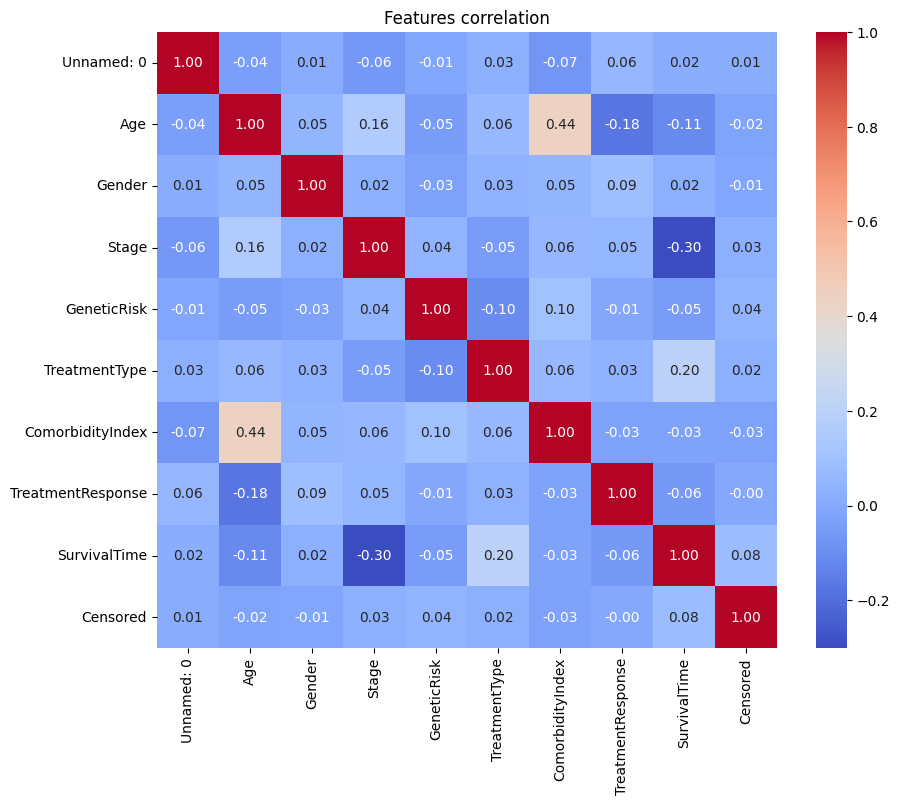

In [180]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8 ))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Features correlation")
plt.show()

##### We can see that there is a significant correlation between the Age and comorbidityIndex, of about 0.44; a correlation between the survival time and Treatment type of 0.2 

In [ ]:
print(df.isnull().sum())

In [183]:
iterative_imputer = IterativeImputer()
knn_imputer = KNNImputer()

df_iterative = df.copy()
df_iterative.iloc[:, :] = iterative_imputer.fit_transform(df)
df_knn = df.copy()
df_knn.iloc[:, :] = knn_imputer.fit_transform(df)

In [185]:
X_iterative = df_iterative.drop(columns=['SurvivalTime', 'Censored'])
y_iterative = df_iterative[['SurvivalTime']]
#Values of censured
censored_iterative = df_iterative['Censored'].values


X_knn = df_knn.drop(columns=['SurvivalTime', 'Censored'])
y_knn = df_knn[['SurvivalTime']]
censored_knn = df_knn[['Censored']].values




In [191]:
X_train,X_val,y_train,y_val = train_test_split(X_iterative,y_iterative,test_size=0.2,random_state=42)
# Convert the dataset to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [193]:
# Define the XGBoost model parameters
params = {
    'max_depth': 10,
    'min_child_weight': 30,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}

In [196]:

bst = xgb.train(params, dtrain, num_boost_round=999, evals=[(dval, "Val")], early_stopping_rounds=5)
# Predict on validation set
y_val_pred = bst.predict(dval)

# Evaluate the model
validation_cMSE = auxMethods.cMSE(y_val_pred, y_val, c_val)
print(f'Validation cMSE: {validation_cMSE}')


[0]	Val-rmse:1.21714
[1]	Val-rmse:1.20775
[2]	Val-rmse:1.20186
[3]	Val-rmse:1.20094
[4]	Val-rmse:1.19990
[5]	Val-rmse:1.20071
[6]	Val-rmse:1.20050
[7]	Val-rmse:1.18517
[8]	Val-rmse:1.20716
[9]	Val-rmse:1.20961
[10]	Val-rmse:1.20855
[11]	Val-rmse:1.22242
[12]	Val-rmse:1.22294


NameError: name 'c_val' is not defined